# Custom Criterion for DecisionTreeRegressor

A [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) can be trained with a couple of possible criterions but it is possible to implement a custom one (see [hellinger_distance_criterion](https://github.com/EvgeniDubov/hellinger-distance-criterion/blob/master/hellinger_distance_criterion.pyx)). See also tutorial [Cython example of exposing C-computed arrays in Python without data copies](http://gael-varoquaux.info/programming/cython-example-of-exposing-c-computed-arrays-in-python-without-data-copies.html) which describes a way to implement fast [cython](https://cython.org/) extensions.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Piecewise data

Let's build a toy problem based on two linear models.

In [3]:
import numpy
import numpy.random as npr
X = npr.normal(size=(1000,4))
alpha = [4, -2]
t = (X[:, 0] + X[:, 3] * 0.5) > 0
switch = numpy.zeros(X.shape[0])
switch[t] = 1
y = alpha[0] * X[:, 0] * t + alpha[1] * X[:, 0] * (1-t) + X[:, 2]

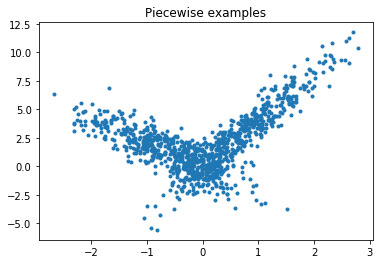

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(X[:, 0], y, ".")
ax.set_title("Piecewise examples");

## DecisionTreeRegressor

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, :1], y)

In [6]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=100)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=100,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [7]:
pred = model.predict(X_test)
pred[:5]

array([-0.02561692,  3.012222  ,  2.98332197, -0.02561692,  0.12258873])

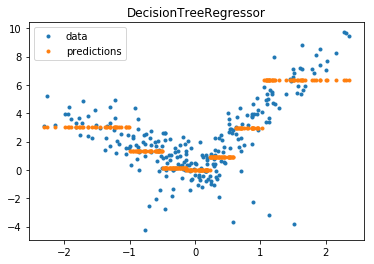

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label='data')
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor")
ax.legend();

## DecisionTreeRegressor with custom criterion

In [9]:
import sklearn
from pyquickhelper.texthelper import compare_module_version
if compare_module_version(sklearn.__version__, '0.21') < 0:
    print("Next step requires scikit-learn >= 0.21")
else:
    print("sklearn.__version__ =", sklearn.__version__)

sklearn.__version__ = 0.21.dev0


In [10]:
from mlinsights.mlmodel.piecewise_tree_regression_criterion import SimpleRegressorCriterion

In [11]:
model2 = DecisionTreeRegressor(min_samples_leaf=100,
                              criterion=SimpleRegressorCriterion(X_train))
model2.fit(X_train, y_train)

DecisionTreeRegressor(criterion=<src.mlinsights.mlmodel.piecewise_tree_regression_criterion.SimpleRegressorCriterion object at 0x000001A53E4A0C30>,
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=None, splitter='best')

In [12]:
pred = model2.predict(X_test)
pred[:5]

array([ 0.0882736 ,  2.72537346,  4.70485086,  0.0882736 , -0.01232004])

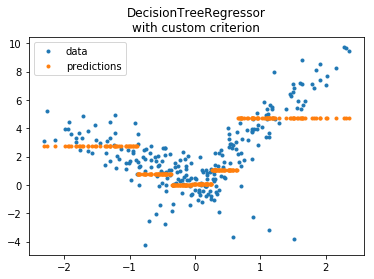

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label='data')
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith custom criterion")
ax.legend();

## Computation time

The custom criterion is not really efficient but it was meant that way. The code can be found in [piecewise_tree_regression_criterion](https://github.com/sdpython/mlinsights/blob/master/src/mlinsights/mlmodel/piecewise_tree_regression_criterion.pyx). Bascially, it is slow because each time the algorithm optimizing the tree needs the class Criterion to evaluate the impurity reduction for a split, the computation happens on the whole data under the node being split. The implementation in [_criterion.pyx](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_criterion.pyx) does it once.

In [14]:
%timeit model.fit(X_train, y_train)

853 µs ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%timeit model2.fit(X_train, y_train)

71.2 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


A loop is involved every time the criterion of the node is involved which raises a the computation cost of lot. The method ``_mse`` is called each time the algorithm training the decision tree needs to evaluate a cut, one cut involves elements betwee, position ``[start, end[``.

```
cdef void _mean(self, SIZE_t start, SIZE_t end, DOUBLE_t *mean, DOUBLE_t *weight) nogil:
    if start == end:
        mean[0] = 0.
        return
    cdef DOUBLE_t m = 0.
    cdef DOUBLE_t w = 0.
    cdef int k
    for k in range(start, end):
        m += self.sample_wy[k]
        w += self.sample_w[k]
    weight[0] = w
    mean[0] = 0. if w == 0. else m / w

cdef double _mse(self, SIZE_t start, SIZE_t end, DOUBLE_t mean, DOUBLE_t weight) nogil:
    if start == end:
        return 0.
    cdef DOUBLE_t squ = 0.
    cdef int k
    for k in range(start, end):            
        squ += (self.y[self.sample_i[k], 0] - mean) ** 2 * self.sample_w[k]
    return 0. if weight == 0. else squ / weight
```

## Better implementation

I rewrote my first implementation to be closer to what *scikit-learn* is doing. The criterion is computed once for all possible cut and then retrieved on demand. The code is below, arrays ``sample_wy_left`` is the cumulated sum of $weight * Y$ starting from the left side (lower *Y*). The loop disappeared.

```
cdef void _mean(self, SIZE_t start, SIZE_t end, DOUBLE_t *mean, DOUBLE_t *weight) nogil:
    if start == end:
        mean[0] = 0.
        return
    cdef DOUBLE_t m = self.sample_wy_left[end-1] - (self.sample_wy_left[start-1] if start > 0 else 0)
    cdef DOUBLE_t w = self.sample_w_left[end-1] - (self.sample_w_left[start-1] if start > 0 else 0)
    weight[0] = w
    mean[0] = 0. if w == 0. else m / w

cdef double _mse(self, SIZE_t start, SIZE_t end, DOUBLE_t mean, DOUBLE_t weight) nogil:
    if start == end:
        return 0.
    cdef DOUBLE_t squ = self.sample_wy2_left[end-1] - (self.sample_wy2_left[start-1] if start > 0 else 0)
    # This formula only holds if mean is computed on the same interval.
    # Otherwise, it is squ / weight - true_mean ** 2 + (mean - true_mean) ** 2.
    return 0. if weight == 0. else squ / weight - mean ** 2
```

In [16]:
from mlinsights.mlmodel.piecewise_tree_regression_criterion_fast import SimpleRegressorCriterionFast
model3 = DecisionTreeRegressor(min_samples_leaf=100,
                              criterion=SimpleRegressorCriterionFast(X_train))
model3.fit(X_train, y_train)
pred = model3.predict(X_test)
pred[:5]

array([ 0.0882736 ,  2.72537346,  4.70485086,  0.0882736 , -0.01232004])

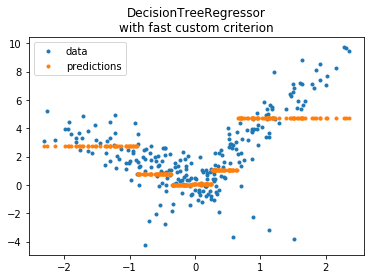

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label='data')
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith fast custom criterion")
ax.legend();

In [18]:
%timeit model3.fit(X_train, y_train)

937 µs ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Much better even though this implementation is currently 3, 4 times slower than scikit-learn's. Let's check with a datasets three times bigger to see if it is a fix cost or a cost.

In [19]:
import numpy
X_train3 = numpy.vstack([X_train, X_train, X_train])
y_train3 = numpy.hstack([y_train, y_train, y_train])

In [20]:
X_train.shape, X_train3.shape, y_train3.shape

((750, 1), (2250, 1), (2250,))

In [21]:
%timeit model.fit(X_train3, y_train3)

2.69 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The criterion needs to be reinstanciated since it depends on the features *X*. The computation does not but the design does. This was introduced to compare the current output with a decision tree optimizing for a piecewise linear regression and not a stepwise regression.

In [22]:
try:
    model3.fit(X_train3, y_train3)
except Exception as e:
    print(e)

X.shape=[750, 1, 0, 0, 0, 0, 0, 0] -- y.shape=[2250, 1, 0, 0, 0, 0, 0, 0]


In [23]:
model3 = DecisionTreeRegressor(min_samples_leaf=100,
                              criterion=SimpleRegressorCriterionFast(X_train3))
%timeit model3.fit(X_train3, y_train3)

3.48 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Still 2 times slower but of the same order of magnitude. We could go further and investigate why or continue and introduce a criterion which optimizes a piecewise linear regression instead of a stepwise regression.